<a href="https://colab.research.google.com/github/kazirafi17/CustomerSegmentation/blob/main/CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Name : Customer Segmentation

#### Description:

`Customer segmentation` simply means grouping your customers according to various characteristics (for example grouping customers by location).It’s a way for organizations to understand their customers. Knowing the differences between customer groups, it’s easier to make strategic decisions regarding product growth and marketing.

But, doing segmentation manually can be exhausting. Why not employ machine learning to do it for us? In this machine learning project, I’ll show you how to do just that. Stay tunned!




# 1. Import Libraries and framework

In [2]:
# import required libraries for dataframe and visualization

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px

In [3]:
# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# 2. Load/Import and Read the datasets

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Online Retail.xlsx')

In [5]:
df.head(5) # Display the first 5 rows of the DataFrame

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 3. Data Cleaning and Preprocessing

#### 3.1 Explore the datasets

In [6]:
df.info() # Display information about the DataFrame, including the data types and non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.describe()  # Display summary statistics for numerical columns

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [8]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [9]:
df.nunique()  # Display the number of unique values in each column

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [10]:
df.duplicated().sum() # Check for duplicate rows in the DataFrame and return a boolean Series

5268

#### Import insights:

*   0.27% and 25.16% of `Description` and `CustomerID` values are missing respectively.
*   Total 8 columns including 4 object, 2 floats, 1 int and 1 datetime. Dataset contains 5.4Lakhs rows.
*   It contains 5268 duplicated values.





#### 3.2 Handling Missing Values and Duplicates

In [11]:
df.drop_duplicates(inplace=True) # Remove duplicate rows from the DataFrame

In [12]:
df['Description'].mode() # Find the mode of Description feature.
df['Description'].fillna(df['Description'].mode()[0], inplace=True) # Fill the missing values of Description column by it's mode value.

In [13]:
df = df.dropna() # Droping rows having missing values

# 4. Feature Engineering

In [14]:
# Create a new feature

df['Amount'] = df['Quantity'] * df['UnitPrice']

In [15]:
# Calculate sum of amount spend by each customers

df_amnt = df.groupby('CustomerID')['Amount'].sum().reset_index()
df_amnt.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [16]:
# Filter the DataFrame to include only the customers who have an 'Amount' less than 0
# This creates a new DataFrame containing customers who never bought anything or gave back products
df_non_buyers = df_amnt[df_amnt['Amount'] <= 0]

# Print the number of customers who didn't buy anything or gave back products
print(df_non_buyers.shape[0], "Number of customers didn't buy anything or gave back products. Samples are:")

# Filter the original DataFrame df to include only those customers whose CustomerID
# is present in the df_non_buyers DataFrame
df_filtered = df[df['CustomerID'].isin(df_non_buyers['CustomerID'])]
df_filtered.sample(3)
#df_filtered.shape

50 Number of customers didn't buy anything or gave back products. Samples are:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
21757,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany,-4.2
177223,C552049,22926,IVORY GIANT GARDEN THERMOMETER,-4,2011-05-06 10:00:00,5.95,17548.0,United Kingdom,-23.8
5233,C536850,22689,DOORMAT MERRY CHRISTMAS RED,-50,2010-12-03 09:47:00,6.75,14213.0,United Kingdom,-337.5


**Negative values** in the graph typically indicate returns or cancellations of products. When customers return items, the amount is recorded as negative to reflect the subtraction from the total sales and inventory.

**Returns**: Customers returned items, which results in a negative quantity to account for the items being added back to inventory.

**Cancellations**: Orders that were canceled and the items were not actually sold, thus the negative quantity.

In [17]:
df = df.drop(df_filtered.index)

In [18]:
# Group the DataFrame 'df' by 'CustomerID' and count the unique 'InvoiceNo' values for each customer.
# This creates a DataFrame with 'CustomerID' and 'InvoiceNo' columns,
# where 'InvoiceNo' represents the count of unique invoices for each customer.
df_invc = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Rename the 'InvoiceNo' column to 'Frequency' to indicate the number of unique invoices for each customer.
df_invc.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

# Display the first few rows of the resulting DataFrame to verify the results.
df_invc.head()


,CustomerID,Frequency
0,12347.0,7
1,12348.0,4
2,12349.0,1
3,12350.0,1
4,12352.0,11


In [19]:
# Convert to datetime to proper datatype
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

# Compute the maximum date to know the last transaction date in our dataset
max_date = max(df['InvoiceDate'])

# Calculate the time difference between the maximum date in the dataset and the transaction date for each record
df['DaysSinceLastPurchase'] = max_date - df['InvoiceDate']

# Extract the days only from the time difference
df['DaysSinceLastPurchase'] = df['DaysSinceLastPurchase'].dt.days

# Group by CustomerID and calculate the minimum difference (Recency) for each customer
df_date = df.groupby('CustomerID')['DaysSinceLastPurchase'].min().reset_index()

# Display the first 5 rows of the resulting DataFrame
df_date.head()

,CustomerID,DaysSinceLastPurchase
0,12347.0,1
1,12348.0,74
2,12349.0,18
3,12350.0,309
4,12352.0,35


In [20]:
# Merge df_amnt and df_invc on 'CustomerID'
df_merged1 = pd.merge(df_amnt, df_invc, on='CustomerID', how='inner')

# Merge the result with df_date on 'CustomerID'
df_final = pd.merge(df_merged1, df_date, on='CustomerID', how='inner')
df_final.head(5)

,CustomerID,Amount,Frequency,DaysSinceLastPurchase
0,12347.0,4310.00,7,1
1,12348.0,1797.24,4,74
2,12349.0,1757.55,1,18
3,12350.0,334.40,1,309
4,12352.0,1545.41,11,35


In [21]:
# Calculate the total spending per visit for each customer by dividing the amount by frequency.
# The new column is named 'Avg_Spending_Per_Visit' to indicate average spending per visit.
# Round the result to two decimal places.
df_final['Avg_Spending_Per_Visit'] = (df_final['Amount'] / df_final['Frequency']).round(2)

# Display the first few rows of the DataFrame to verify the results.
df_final.head()

,CustomerID,Amount,Frequency,DaysSinceLastPurchase,Avg_Spending_Per_Visit
0,12347.0,4310.00,7,1,615.71
1,12348.0,1797.24,4,74,449.31
2,12349.0,1757.55,1,18,1757.55
3,12350.0,334.40,1,309,334.40
4,12352.0,1545.41,11,35,140.49


# 4. Explanatory Data Analysis

#### 4.1 Uni-variate Analysis for continous variables

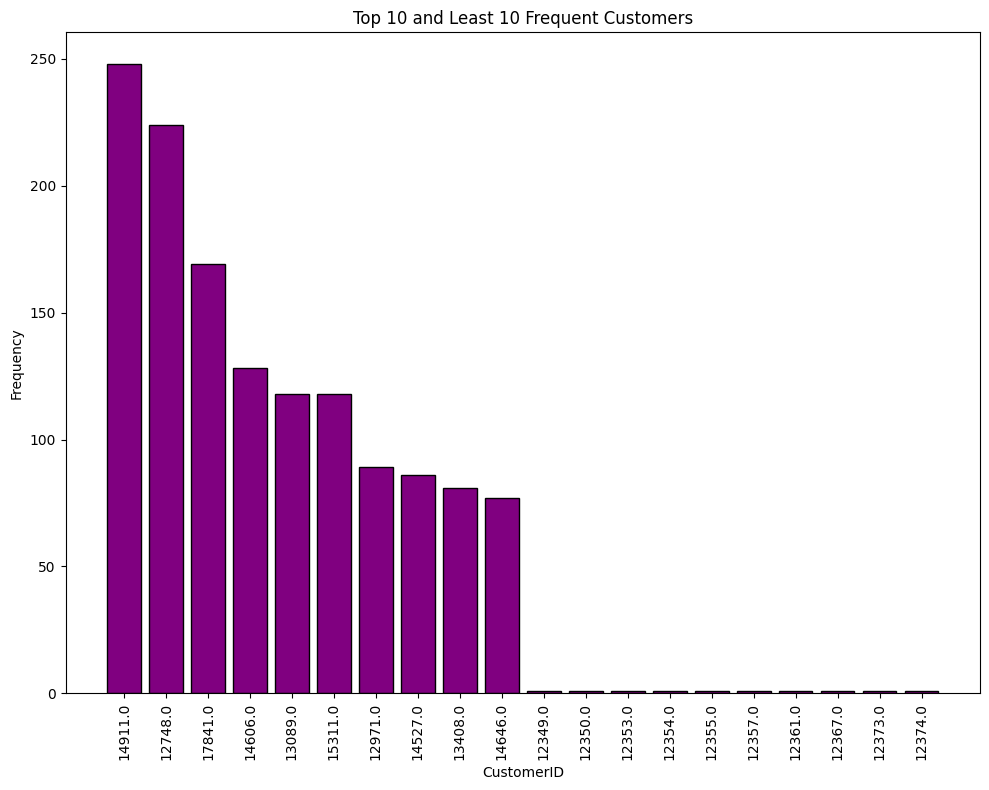

In [22]:
# Sort the dataframe by 'Frequency' in descending order and select the top 10
top_10_customers = df_final.nlargest(10, 'Frequency')

# Sort the dataframe by 'Frequency' in ascending order and select the bottom 10
least_10_customers = df_final.nsmallest(10, 'Frequency')

# Combine the top 10 and bottom 10 customers
combined = pd.concat([top_10_customers, least_10_customers])

# Plotting the bar chart for combined customers with CustomerID on x-axis
plt.bar(combined['CustomerID'].astype(str), combined['Frequency'], color='purple', edgecolor='black')
plt.gcf().set_size_inches(10, 8)
plt.title('Top 10 and Least 10 Frequent Customers')
plt.xlabel('CustomerID')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

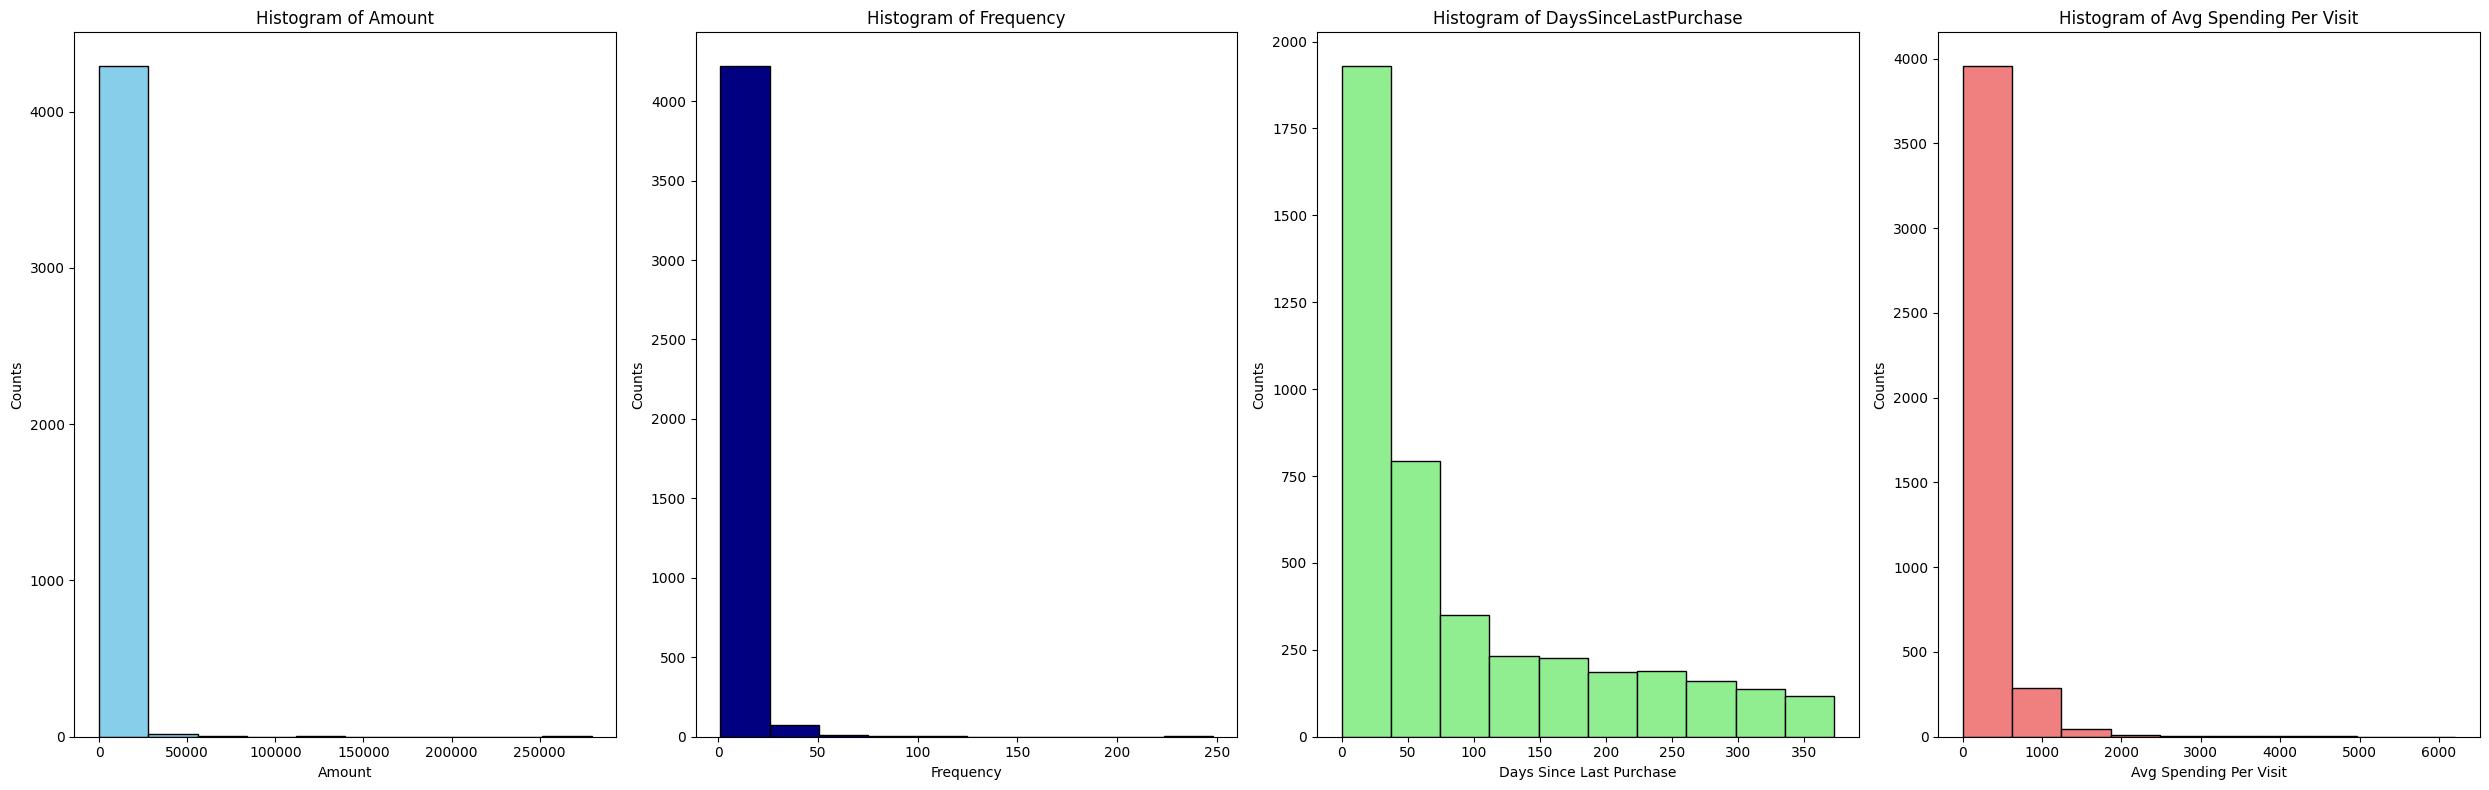

In [23]:
# Plotting univariate analysis in 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(25,8))

# Histogram of Amount
axs[0].hist(df_final['Amount'], bins=10, color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of Amount')
axs[0].set_xlabel('Amount')
axs[0].set_ylabel('Counts')

# Histogram of Frequency
axs[1].hist(df_final['Frequency'], bins=10, color='navy', edgecolor='black')
axs[1].set_title('Histogram of Frequency')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Counts')

# Histogram of DaysSinceLastPurchase
axs[2].hist(df_final['DaysSinceLastPurchase'], bins=10, color='lightgreen', edgecolor='black')
axs[2].set_title('Histogram of DaysSinceLastPurchase')
axs[2].set_xlabel('Days Since Last Purchase')
axs[2].set_ylabel('Counts')

# Histogram of Avg_Spending_Per_Visit
axs[3].hist(df_final['Avg_Spending_Per_Visit'], bins=10, color='lightcoral', edgecolor='black')
axs[3].set_title('Histogram of Avg Spending Per Visit')
axs[3].set_xlabel('Avg Spending Per Visit')
axs[3].set_ylabel('Counts')

plt.tight_layout()
plt.show()


**Observations:**



*   Top 10 frequent customers visit 30 or more times and some customers visits for only one time.

*   Histogram of Amount: A significant number of purchases are under 2000 units.There are very few purchases with high amounts, with the frequency dropping sharply as the amount increases.

*   Histogram of Frequency:The frequency of purchases per customer is heavily skewed towards the lower end.Most customers have a low purchase frequency, typically between 1 and 5.A small number of customers have higher purchase frequencies, but these are much less common.

*  Histogram of DaysSinceLastPurchase: This distribution is right-skewed, indicating that many customers made recent purchases.A large number of customers made their last purchase very recently (0-50 days).There is a gradual decline in the number of customers as the days since the last purchase increase.



*   Histogram of Avg Spending Per Visit:The average spending per visit is concentrated around lower values, with a significant number of visits having spending around 0 to 500 units.There is a steep drop-off in frequency as the average spending per visit increases.Very few visits have an average spending that is very high (above 1000 units).






4.2 Multi-variate Analysis for continous variables

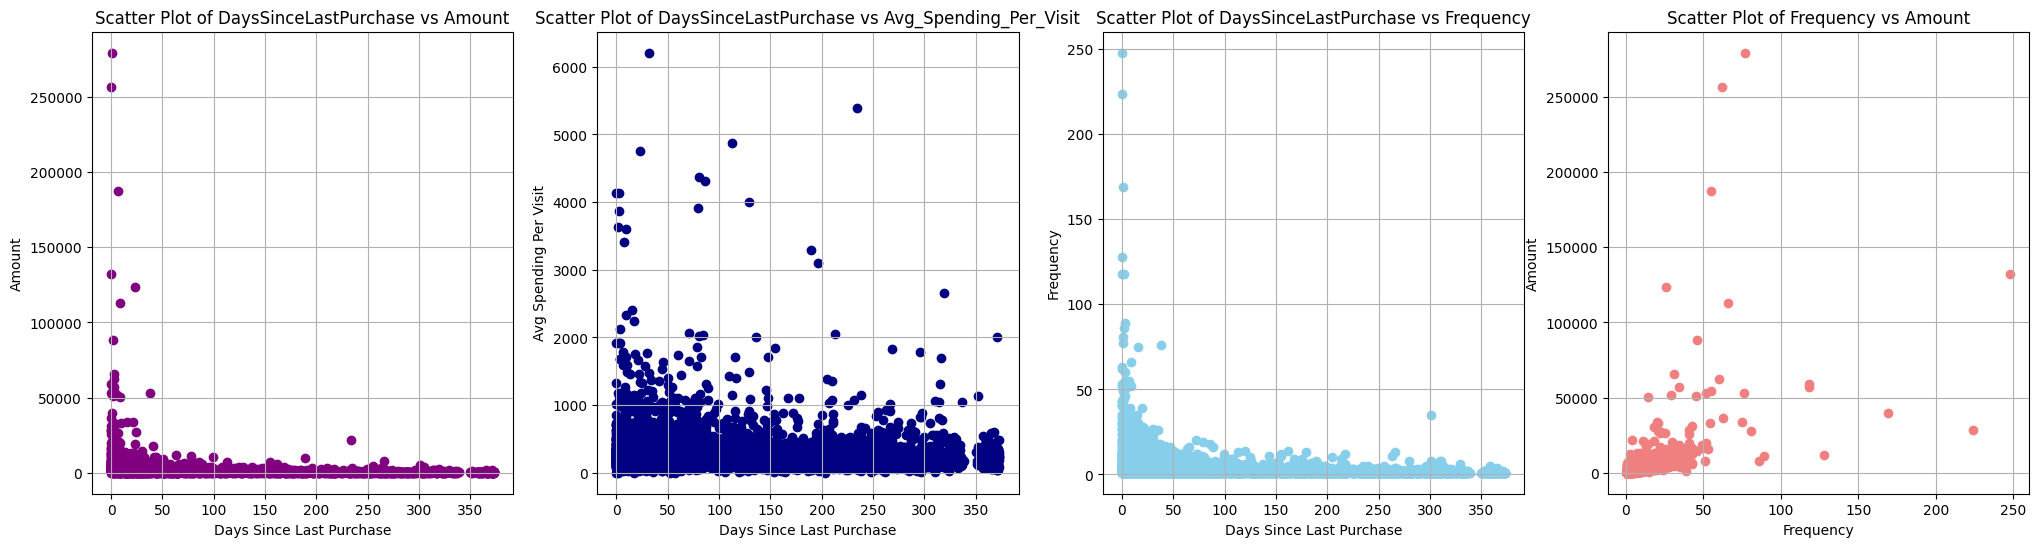

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(25, 6))

# Create a sub scatter plot of DaysSinceLastPurchase vs Amount
axs[0].scatter(df_final['DaysSinceLastPurchase'], df_final['Amount'], color='purple')
axs[0].set_title('Scatter Plot of DaysSinceLastPurchase vs Amount')
axs[0].set_xlabel('Days Since Last Purchase')
axs[0].set_ylabel('Amount')

# Create a sub scatter plot of DaysSinceLastPurchase vs Avg_Spending_Per_Visit
axs[1].scatter(df_final['DaysSinceLastPurchase'], df_final['Avg_Spending_Per_Visit'], color='navy')
axs[1].set_title('Scatter Plot of DaysSinceLastPurchase vs Avg_Spending_Per_Visit')
axs[1].set_xlabel('Days Since Last Purchase')
axs[1].set_ylabel('Avg Spending Per Visit')

# Create a sub scatter plot of DaysSinceLastPurchase vs Frequency
axs[2].scatter(df_final['DaysSinceLastPurchase'], df_final['Frequency'], color='skyblue')
axs[2].set_title('Scatter Plot of DaysSinceLastPurchase vs Frequency')
axs[2].set_xlabel('Days Since Last Purchase')
axs[2].set_ylabel('Frequency')

# Create a sub scatter plot of Frequency vs Amount
axs[3].scatter(df_final['Frequency'], df_final['Amount'], color='lightcoral')
axs[3].set_title('Scatter Plot of Frequency vs Amount')
axs[3].set_xlabel('Frequency')
axs[3].set_ylabel('Amount')

# Add grid lines to all subplots
for ax in axs:
    ax.grid(True)

plt.show()


**General Insights:**

*   Recent and frequent customers tend to spend more, both in total and per visit.
*   Customers who have not made purchases for a longer period tend to have lower overall spending and frequency.

**`Encouraging frequent visits and reducing the time between purchases could potentially increase total spending.`**



#### Removing Outliers

In [25]:
# Removing (statistical) outliers for DaysSinceLastPurchase
Q1 = df_final['DaysSinceLastPurchase'].quantile(0.05)
Q3 = df_final['DaysSinceLastPurchase'].quantile(0.80)
IQR = Q3 - Q1
df_final = df_final[(df_final['DaysSinceLastPurchase'] >= Q1 - 1.5 * IQR) & (df_final['DaysSinceLastPurchase'] <= Q3 + 1.5 * IQR)]

# Removing (statistical) outliers for Avg_Spending_Per_Visit
Q1 = df_final['Avg_Spending_Per_Visit'].quantile(0.05)
Q3 = df_final['Avg_Spending_Per_Visit'].quantile(0.95)  # Corrected to 95th percentile
IQR = Q3 - Q1
df_final = df_final[(df_final['Avg_Spending_Per_Visit'] >= Q1 - 1.5 * IQR) & (df_final['Avg_Spending_Per_Visit'] <= Q3 + 1.5 * IQR)]

# Removing (statistical) outliers for Amount
Q1 = df_final['Amount'].quantile(0.05)
Q3 = df_final['Amount'].quantile(0.95)  # Corrected to 95th percentile
IQR = Q3 - Q1
df_final = df_final[(df_final['Amount'] >= Q1 - 1.5 * IQR) & (df_final['Amount'] <= Q3 + 1.5 * IQR)]

# Removing (statistical) outliers for Frequency
Q1 = df_final['Frequency'].quantile(0.05)
Q3 = df_final['Frequency'].quantile(0.95)  # Corrected to 95th percentile
IQR = Q3 - Q1
df_final = df_final[(df_final['Frequency'] >= Q1 - 1.5 * IQR) & (df_final['Frequency'] <= Q3 + 1.5 * IQR)]


#### Scaling:

Scaling data before plotting ensures that the variables are on the same scale, making it easier to interpret the box plot, especially when variables have different units or ranges. Adjust the parameters and customization as per your specific data and visualization requirements.

In [26]:
# Define attributes to plot
attributes = ['DaysSinceLastPurchase', 'Avg_Spending_Per_Visit', 'Amount', 'Frequency']

# Perform standardization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_final[attributes])

# Convert scaled data back to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=attributes)

# Create the box plot using Plotly Express
fig = px.box(df_scaled.melt(var_name='Attributes', value_name='Range'),
             y='Range', x='Attributes', points='outliers', boxmode='group',
             title="Outliers Variable Distribution (Scaled)",
             labels={'Attributes': 'Attributes', 'Range': 'Range'},
             color_discrete_sequence=['navy'],  # Ensure all elements are purple
             width=800, height=600)

# Update layout with axis titles
fig.update_layout(
    xaxis=dict(title="Attributes", title_font=dict(size=14)),
    yaxis=dict(title="Range (Standardized)", title_font=dict(size=14)),
    showlegend=False
)

# Show the plot
fig.show()

In [27]:
final_data = df_scaled.drop(['Amount','Frequency'],axis=1)

# Building the model:

The elbow score for k=1: is 8435.999999999987
The elbow score for k=2: is 5028.419950065748
The elbow score for k=3: is 2762.8613179972604
The elbow score for k=4: is 2071.5817438488975
The elbow score for k=5: is 1679.6481130735629
The elbow score for k=6: is 1407.7683571546154
The elbow score for k=7: is 1176.1268141486992
The elbow score for k=8: is 1068.1787013283517
The elbow score for k=9: is 943.9382288862388
The elbow score for k=10: is 842.7875249185614


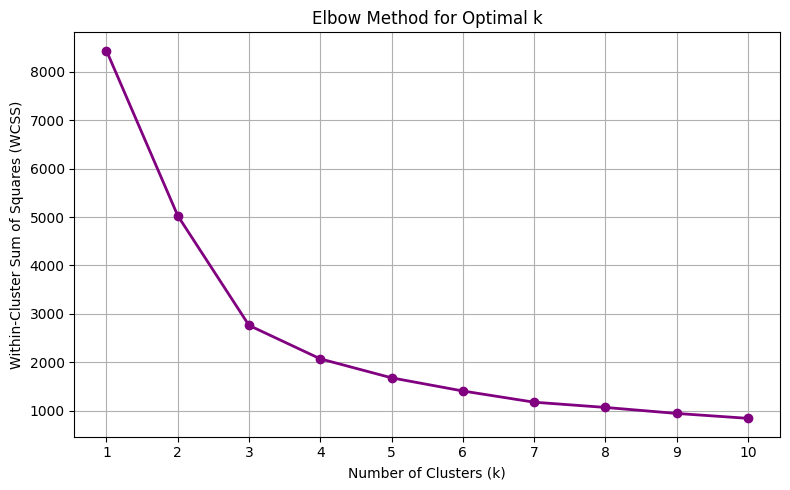

In [28]:

# Define range of k values to test
k_values = range(1, 11)
wcss = []  # Within cluster sum of squares

# Calculate WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_data)
    wcss_score = kmeans.inertia_
    wcss.append(wcss_score)
    print(f"The elbow score for k={k}: is {wcss_score}")

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='purple', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

The decrease after k=4 is more gradual, suggesting that the optimal number of clusters is likely around **k=3 or k=4.**

In [29]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(final_data)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(final_data, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


For n_clusters=2, the silhouette score is 0.5054643904134708
For n_clusters=3, the silhouette score is 0.551461676111317
For n_clusters=4, the silhouette score is 0.4531326808111078
For n_clusters=5, the silhouette score is 0.43964750696685967
For n_clusters=6, the silhouette score is 0.41609467011949736
For n_clusters=7, the silhouette score is 0.4269900648856571
For n_clusters=8, the silhouette score is 0.4057579626875885



*  The silhouette score is highest for **n_clusters=3** (0.551), indicating that three clusters provide the best-defined clusters among the tested values.





**Conclusion**


Based on both the elbow method and the silhouette scores:

The elbow method suggests that the optimal number of clusters might be around 3 or 4.
The silhouette score analysis indicates that 3 clusters provide the best separation.
Therefore, the most appropriate number of clusters for your data seems to be 3.

In [30]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(final_data)

KMeans(max_iter=50, n_clusters=3)

In [31]:
kmeans.labels_

array([2, 0, 2, ..., 0, 0, 2], dtype=int32)

In [32]:
# assign the label
df_final['Cluster_Id'] = kmeans.labels_
df_final

,CustomerID,Amount,Frequency,DaysSinceLastPurchase,Avg_Spending_Per_Visit,Cluster_Id
0,12347.0,4310.00,7,1,615.71,2
1,12348.0,1797.24,4,74,449.31,0
2,12349.0,1757.55,1,18,1757.55,2
3,12350.0,334.40,1,309,334.40,1
4,12352.0,1545.41,11,35,140.49,0
...,...,...,...,...,...,...
4317,18280.0,180.60,1,277,180.60,1
4318,18281.0,80.82,1,180,80.82,1
4319,18282.0,176.60,3,7,58.87,0
4320,18283.0,2045.53,16,3,127.85,0


In [33]:
fig = px.box(df_final, x='Cluster_Id', y='DaysSinceLastPurchase',
             title="Cluster Id vs DaysSinceLastPurchase Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'DaysSinceLastPurchase': 'DaysSinceLastPurchase'},
             color='Cluster_Id')

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="DaysSinceLastPurchase", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [34]:
fig = px.scatter(df_final, x='Cluster_Id', y='Avg_Spending_Per_Visit', color='Frequency',
                 title='Cluster ID vs Avg_Spending_Per_Visit (Color Encoded by Frequency)',
                 labels={'Cluster_Id': 'Cluster ID', 'Avg_Spending_Per_Visit': 'Avg_Spending_Per_Visit', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=8)),
    yaxis=dict(title="Avg_Spending_Per_Visitunt", title_font=dict(size=14)),
    showlegend=True,
    width=800,
    height=600
)

fig.show()

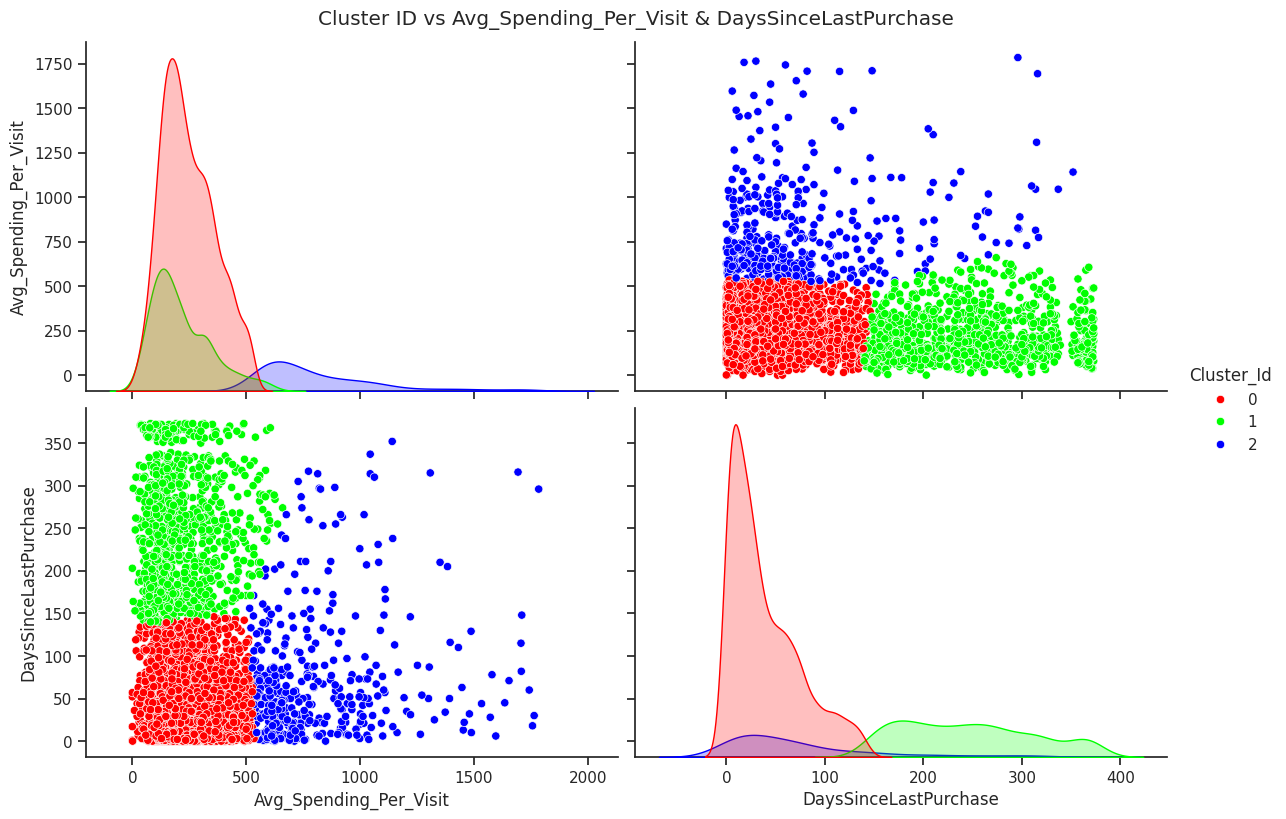

In [35]:
# Create a custom color palette with Red, Green, and Blue
custom_palette = sns.color_palette(["#FF0000", "#00FF00", "#0000FF"])

# Create a scatter plot matrix with separate plots for each cluster, custom palette, and a larger size
sns.set(style="ticks")
sns.pairplot(df_final, hue='Cluster_Id', vars=['Avg_Spending_Per_Visit', 'DaysSinceLastPurchase'], palette=custom_palette, height=4, aspect=1.5)
plt.suptitle('Cluster ID vs Avg_Spending_Per_Visit & DaysSinceLastPurchase', y=1.02)
plt.show()

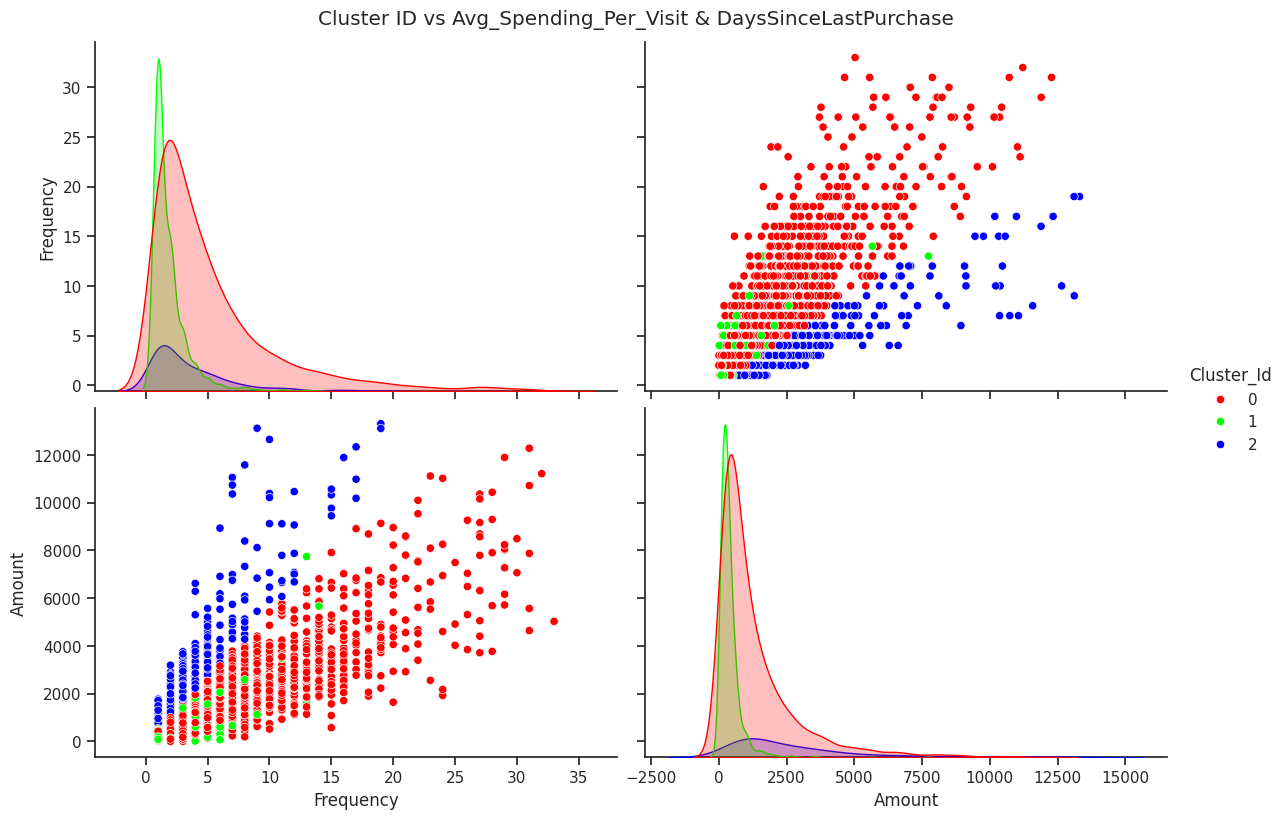

In [36]:
# Create a custom color palette with Red, Green, and Blue
custom_palette = sns.color_palette(["#FF0000", "#00FF00", "#0000FF"])

# Create a scatter plot matrix with separate plots for each cluster, custom palette, and a larger size
sns.set(style="ticks")
sns.pairplot(df_final, hue='Cluster_Id', vars=['Frequency', 'Amount'], palette=custom_palette, height=4, aspect=1.5)
plt.suptitle('Cluster ID vs Avg_Spending_Per_Visit & DaysSinceLastPurchase', y=1.02)
plt.show()

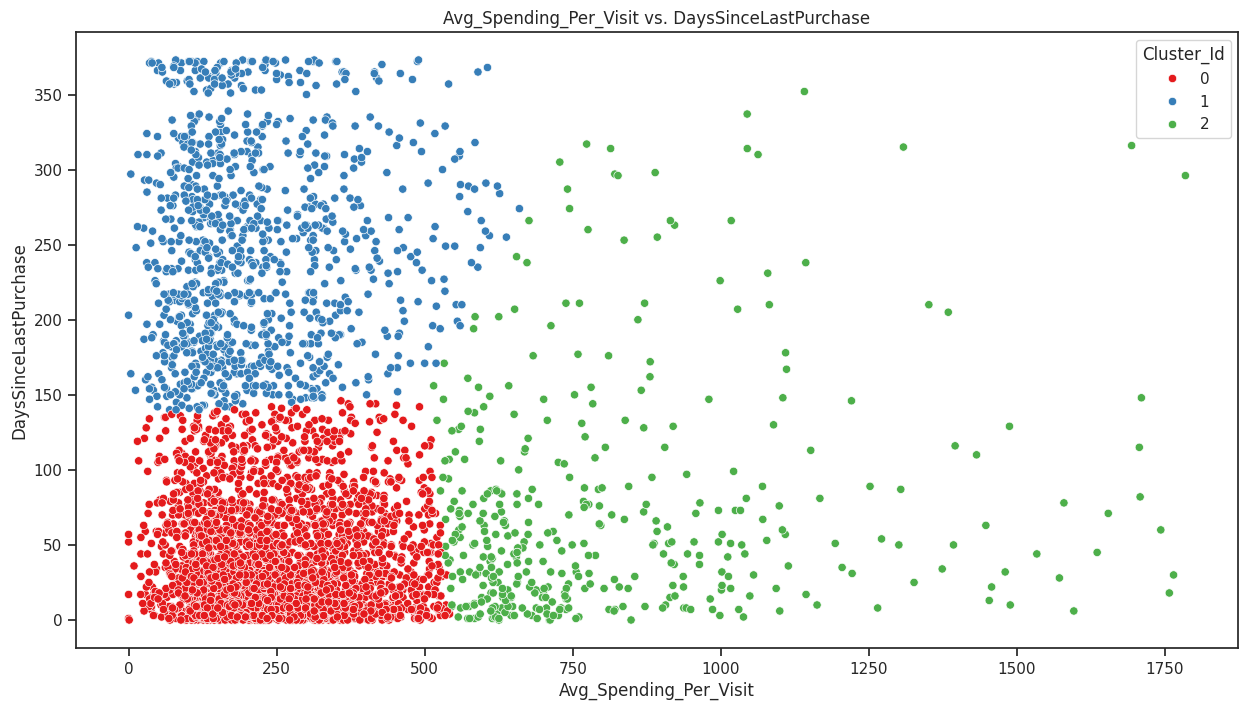

In [37]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(15, 8))  # Adjust the figure size here


# Amount vs. Frequency
sns.scatterplot(x='Avg_Spending_Per_Visit', y='DaysSinceLastPurchase', hue='Cluster_Id', data=df_final, palette='Set1')
plt.title('Avg_Spending_Per_Visit vs. DaysSinceLastPurchase')
plt.show()

In [38]:
import plotly.express as px

df_final['Cluster_3D'] = kmeans.fit_predict(final_data)

# Create a 3D scatter plot matrix with Plotly
fig = px.scatter_3d(df_final, x='Avg_Spending_Per_Visit', y='Frequency', z='DaysSinceLastPurchase', color='Cluster_3D',
                     labels={'Avg_Spending_Per_Visit': 'Avg_Spending_Per_Visit', 'Frequency': 'Frequency', 'DaysSinceLastPurchase': 'DaysSinceLastPurchase', 'Cluster_3D': 'Cluster'})

fig.update_layout(
    scene=dict(
        xaxis_title='Avg_Spending_Per_Visit',
        yaxis_title='Frequency',
        zaxis_title='DaysSinceLastPurchase',
    ),
    title='Clustering by Avg_Spending_Per_Visit, Frequency, and DaysSinceLastPurchase',
    width=800,
    height=600
)

fig.show()


**Conclusion:**

It’s not wise to serve all customers with the same product model, email, text message campaign, or ad. Customers have different needs. A one-size-for-all approach to business will generally result in less engagement, lower-click through rates, and ultimately fewer sales. Customer segmentation is the cure for this problem.

Finding an optimal number of unique customer groups will help you understand how your customers differ, and help you give them exactly what they want. Customer segmentation improves customer experience and boosts company revenue. That’s why segmentation is a must if you want to surpass your competitors and get more customers. Doing it with machine learning is definitely the right way to go.

If you made it this far, thanks for your valuable time!

In [39]:
#import pickle

# Path to save the pickle file
#pkl_filename = "customer_segmentation.pkl"

# Save the model to a pickle file
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(kmeans, file)

#print(f"Model saved to {pkl_filename}")


Model saved to customer_segmentation.pkl
